In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

# Multivariate Gaussian Process Regression

## Objectives

+ Perform multivariate Gaussian process regression with automatic relevance determination.

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\W}{\mathbf{W}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\E}{\mathbf{E}}
$$

## Multivariate Gaussian Process Regression

When we say "multivariate" here we refer to many function inputs, not outputs.
This just means that the input of the function we are interested in learning is a vector $\mathbf{x}$ in $\mathbb{R}^D$.
In that regard, nothing really changes compared to one-input GPR.
The formulas are exactly the same.
However, in higher dimensional settings one must pay attention to the selection of the covariance function.

Let's demonstrate this using an example.
Here is an analytical function, known as the Branin-Hoo function:

$$
f(\mathbf{x}) = f(x_1,x_2) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right]
$$

Here $\mathbf{x} = (x_1, x_2)$ and it takes values in $[0,1]^2$.
We will use this function to generate some synthetic data.
Let's superimpose the synthetic data on a contour of this function.

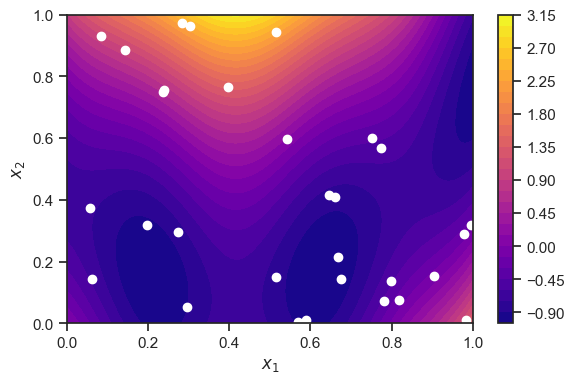

In [2]:
# Define the function
def f_branin(x):
    """Input must be 2D array of size N x 2."""
    return (
        1.0 / 51.95
        * (
            (
                15.0 * x[:, 1]
                - 5.1 * (
                    (15.0 * x[:, 0]) ** 2
                    / (4.0 * np.pi ** 2)
                )
                + 75.0 * x[:, 0] / np.pi
                - 6.0
            ) ** 2
            + (
                (10.0 - 10.0 / (8.0 * np.pi))
                * np.cos(15.0 * x[:, 0])
            )
            - 44.81
        )
    )


N = 30
Xdata = np.random.rand(N, 2)
sigma = 0.01
Ydata = f_branin(Xdata)[:, None] + sigma * np.random.randn(N, 1)

fig = plt.figure()
ax = plt.subplot(111)
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
Xs = np.vstack([X1.flatten(), X2.flatten()]).T
Y = f_branin(Xs).reshape((100, 100))

c = ax.contourf(X1, X2, Y, 30, cmap='plasma')
plt.colorbar(c)
ax.plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

fig.tight_layout()

We will be using a the squared exponential covariance function for a regression along with a zero mean.
So our prior GP is:

$$
f(\cdot)\sim\operatorname{GP}(0, k(\cdot,\cdot)),
$$

with

$$
k(\mathbf{x}, \mathbf{x}') = s^2\exp\left(-\frac{(x_1-x_1')^2}{2\ell_1^2}-\frac{(x_2-x_2')^2}{2\ell_2^2}\right).
$$

The first, situation we are going to examin is when the lengthscales are the same:

$$
\ell_1 = \ell_2.
$$

This is what you get by default from ``GPy``:

In [3]:
import GPy

# The 2 here is for the dimensionality of the input space
k = GPy.kern.RBF(2)
gp = GPy.models.GPRegression(Xdata, Ydata, k)

print(gp)


Name : GP regression
Objective : 39.13997971047789
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Optimize for the hyper-parameters:

In [4]:
gp.optimize(messages=True);

Check the lengthscales:

In [5]:
print(gp.kern.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                          0.313  |      +ve      |        


Make predictions:

In [6]:
Ypred_flat, Yvar_flat = gp.predict(Xs)

Plot predictions:

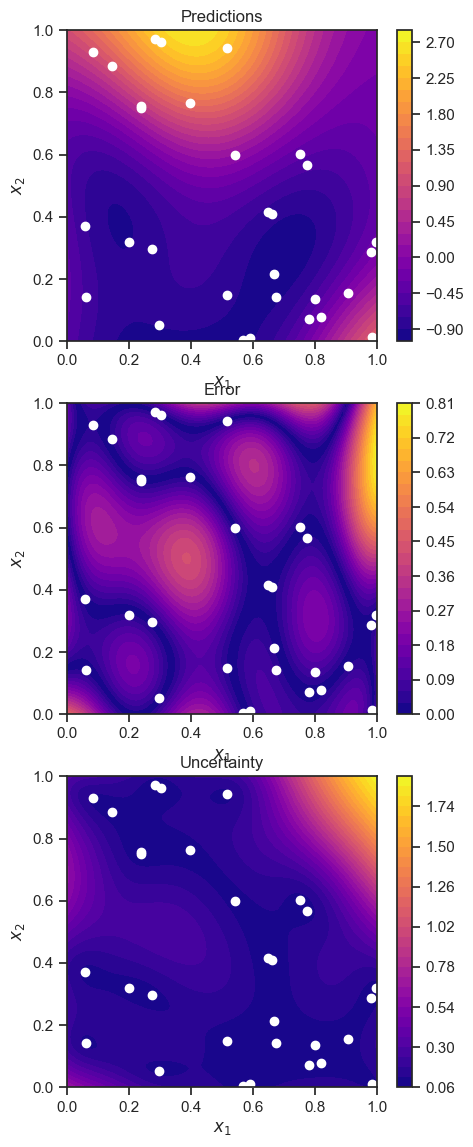

In [7]:
fig, ax = plt.subplots(3,1, figsize=(5, 14))

# Predictions
Ypred = Ypred_flat.reshape((100, 100))
im = ax[0].contourf(X1, X2, Ypred, 30, cmap='plasma')
c = plt.colorbar(im, ax=ax[0])
ax[0].plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Predictions')

# Error
E = np.abs(Y - Ypred)
im = ax[1].contourf(X1, X2, E, 30, cmap='plasma')
ax[1].plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)
c = plt.colorbar(im, ax=ax[1])
ax[1].set_xlabel('$x_1$')
ax[1].set_ylabel('$x_2$')
ax[1].set_title('Error')

# Uncertainty
im = ax[2].contourf(
    X1,
    X2,
    2.0 * np.sqrt(Yvar_flat.reshape(X1.shape)),
    30,
    cmap='plasma'
)
ax[2].set_title('Uncertainty')
c = plt.colorbar(im, ax=ax[2])
ax[2].plot(
    Xdata[:, 0],
    Xdata[:, 1],
    'o',
    color='white'
)
ax[2].set_xlabel('$x_1$')
ax[2].set_ylabel('$x_2$');

Let's get some test data and make some predictions.

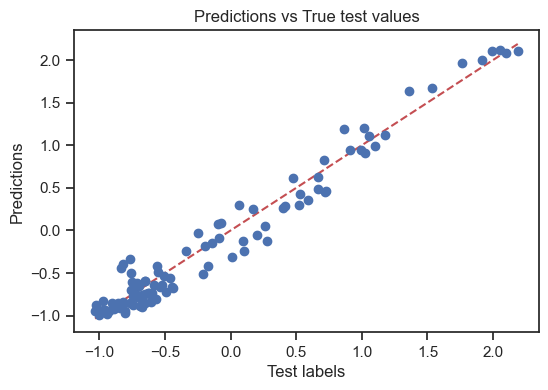

In [8]:
from sklearn.metrics import mean_squared_error

Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()
ys = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions');

Now let's repeat the same analysis but allowing for a different lengthscale per input.
First, we set up and train the model:

In [9]:
k = GPy.kern.RBF(2, ARD=True)
gp = GPy.models.GPRegression(Xdata, Ydata, k)

print(gp)


Name : GP regression
Objective : 39.13997971047789
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |   (2,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that you now cannot see what the lengthscale values are.
You need to do this to see them:

And you can train the model as usual:

In [10]:
gp.optimize(messages=True)
print(gp)
print(gp.rbf.lengthscale)


Name : GP regression
Objective : -9.12138086601402
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       5.542500019348663  |      +ve      |        
  rbf.lengthscale          |                    (2,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00013694305014856943  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                          0.235  |      +ve      |        
  [1]    |                          0.788  |      +ve      |        


So, you see that the lengthscale assigned to $x_1$ is slightly smaller than the lengthscale assigned to $x_2$. This means that the first input is slightly more important than the second input.
This is the automatic relevance determination (ARD) in action.

Now let's try to make some predictions with the ARD version of the GP regression model.

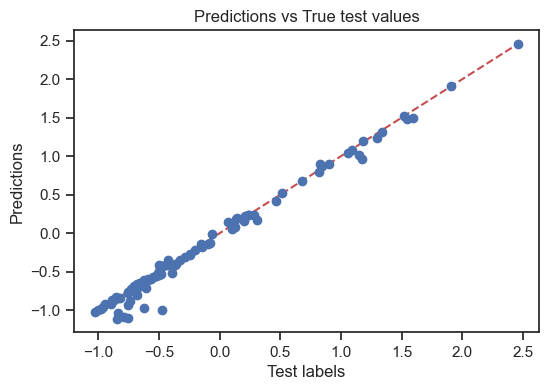

In [11]:
Ntest = 100
Xtest = np.random.rand(Ntest, 2)
Ytest = f_branin(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()

ys = np.linspace( np.min(Ytest), np.max(Ytest), 100 )
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions');

Let's add a third dimension to the Branin function, $x_3$, such that $f$ has a weak linear dependence on $x_3$. 

The added term is highlighted in blue.

$$
f(\mathbf{x}) = f(x_1,x_2, x_3) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] + \color{blue}{0.1 x_3}.
$$

In [12]:
# Define the function
def f_branin_1(x):
    """
    Input must be 2D array of size N x 2.
    """
    return f_branin(x) + 0.1*x[:, 2]

Let's generate some synthetic data and train a GP model with ARD. Let's see if we can discover the weak dependence of $f$ on the newly added 3rd dimension. 

In [13]:
N    = 40
ndim = 3
Xdata = np.random.rand(N, ndim)

sigma = 0.01
Ydata = f_branin_1(Xdata)[:, None] + sigma * np.random.randn(N, 1)

Train a GP:

In [14]:
k = GPy.kern.RBF(ndim, ARD=True) 
gp = GPy.models.GPRegression(Xdata, Ydata, k)

gp.optimize(messages=True)
print(gp.rbf.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                          0.207  |      +ve      |        
  [1]    |                          0.700  |      +ve      |        
  [2]    |                         12.233  |      +ve      |        


Notice from the results above that the lengthscale in the 3rd dimension is very large relative to the lengthscales along the 1st and 2nd dimensions. 
This means that our trained GP model depends very weakly on $x_3$. Clearly, we are able to capture the weak dependence of $f$ on $x_3$. 

Let's make some predictions on the test data:

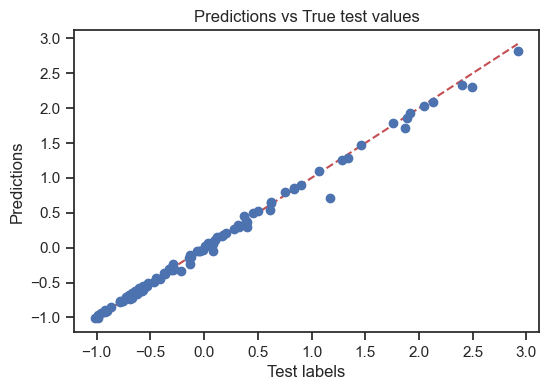

In [15]:
Ntest = 100
Xtest = np.random.rand(Ntest, ndim)
Ytest = f_branin_1(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()

ys = np.linspace(np.min(Ytest), np.max(Ytest), 100)
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions');

Now let's add a fourth dimension to the Branin function, $x_4$, such that $f(x_1, x_2, x_3, x_4) = f(x_1, x_2, x_3)$, i.e., $f$ does not actually depend on $x_4$. 

$$
f(\mathbf{x}) = f(x_1,x_2, x_3, x_4) = \frac{1}{51.95}\left[\left(15x_2 - \frac{5.1(15x_1)^2}{4\pi^2} + \frac{75x_1}{\pi} - 6\right)^2 + \left(10 - \frac{10}{8\pi}\right)\cos(15x_1)-44.81\right] + \color{blue}{0.1 x_3}.
$$

In [16]:
# define the function
def f_branin_2(x):
    assert x.shape[1] == 4, 'The input should be 4 dimensional.'
    return f_branin_1(x[:, :3])

Generate synthetic data:

In [17]:
N    = 40
ndim = 4
Xdata = np.random.rand(N, ndim)

sigma = 0.01
Ydata = f_branin_2(Xdata)[:, None] + sigma * np.random.randn(N, 1)

Train a GP:

In [18]:
k = GPy.kern.RBF(ndim, ARD=True) 
gp = GPy.models.GPRegression(Xdata, Ydata, k)

gp.optimize(messages=True); # No messages shown here
print(gp.rbf.lengthscale)

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                          0.226  |      +ve      |        
  [1]    |                          0.588  |      +ve      |        
  [2]    |                          7.785  |      +ve      |        
  [3]    |                         52.699  |      +ve      |        


Notice that $\ell_4$ is much larger than $\ell_3$, which itself is much larger than $\ell_1$ and $\ell_2$. 
The ARD training procedure discovers that the dependence of the function $f$ is very weak in the input $x_4$.

Now let's make some predictions and compare it to the test observations.

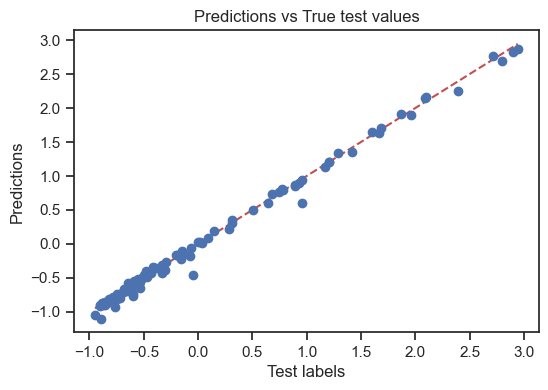

In [19]:
Ntest = 100
Xtest = np.random.rand(Ntest, ndim)
Ytest = f_branin_2(Xtest)[:, None] 
Ytest_m, Ytest_v = gp.predict(Xtest, full_cov=False) 
error_m = np.sqrt( mean_squared_error(Ytest, Ytest_m) )

fig, ax = plt.subplots()

ys = np.linspace(np.min(Ytest), np.max(Ytest), 100)
ax.plot(ys, ys, 'r--', label='$x=y$')
ax.plot(Ytest, Ytest_m, 'o')
ax.set_title('Predictions vs True test values')
ax.set_xlabel('Test labels')
ax.set_ylabel('Predictions');

#### Questions:
For the very last example (4D):
+ Add code cells above that compute the standarized errors and does the quantile-quantile plots.
+ Experiment with very small number of samples $N$. What happens?
+ Experiment with very large number of samples, say $N = 500$. What happens?